In [1]:
import re
import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import os 
myData = '/content/drive/MyDrive/NSU_Courses/CSE/CSE499A/zeror_dataset';
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#reading dataset
train_df = pd.read_excel('/content/drive/MyDrive/NSU_Courses/CSE/CSE499A/zeror_dataset/train.xlsx') 
train_df = train_df.dropna()
#val_df = pd.read_excel('val.xlsx')
test_df = pd.read_excel('/content/drive/MyDrive/NSU_Courses/CSE/CSE499A/zeror_dataset/test.xlsx')
test_df = test_df.dropna()

In [4]:
train_df.head()

,text,emotion,label
0,hefajoter pokkhe michil theke hamlay ahoto awa...,sadness,1
1,e chara mask chara probesh korte dicchi na,anger,4
2,vore uthe batch porano college e class neya ab...,disgust,3
3,eita pata chagler kach,anger,4
4,sob dalal diye vore geche!,disgust,3


In [5]:
#checking for ull values
train_df.info()
print()
test_df.info()
print()
#val_df.info()
#print()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6848 entries, 0 to 6849
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     6848 non-null   object
 1   emotion  6848 non-null   object
 2   label    6848 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 214.0+ KB

<class 'pandas.core.frame.DataFrame'>
Int64Index: 761 entries, 0 to 760
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     761 non-null    object
 1   emotion  761 non-null    object
 2   label    761 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 23.8+ KB



In [6]:
train_df["emotion"].value_counts()

surprise    1199
joy         1175
sadness     1161
anger       1142
fear        1111
disgust     1060
Name: emotion, dtype: int64

In [7]:
test_df["emotion"].value_counts()

disgust     136
anger       130
joy         128
sadness     127
surprise    120
fear        120
Name: emotion, dtype: int64

In [ ]:
#val_df["classes"].value_counts()

In [8]:
#sample text from dataset
sample = train_df["text"][1]
print(sample)

e chara mask chara probesh korte dicchi na


In [9]:
x_train, x_test, y_train, y_test = train_df["text"], test_df["text"], train_df["label"], test_df["label"]

In [10]:
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from keras import layers
from keras.models import Sequential

EPOCHS= 35
act= "swish"
opt= tf.keras.optimizers.Adam(learning_rate=0.001)

In [11]:
#converting text to vectors via tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

X_train = tokenizer.texts_to_sequences(x_train)
X_test = tokenizer.texts_to_sequences(x_test)
TEST = tokenizer.texts_to_sequences(test_df["text"]) 

vocab_size = len(tokenizer.word_index) + 1 

In [12]:
#calculating max length of the vector
lens_train = [len(i) for i in X_train]
lens_test = [len(i) for i in X_test]
lens = lens_train + lens_test

maxlen = np.max(lens)

print('Max len:', maxlen)

Max len: 247


In [13]:
#Zero padding every vector so that they are the same size
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
TEST = pad_sequences(TEST, padding='post', maxlen=maxlen)

In [14]:
#One Hot Encoding integer labels
dummy_y_test = np_utils.to_categorical(y_test)
dummy_y_train = np_utils.to_categorical(y_train)

In [15]:
#reading fasttext
def get_embedding_vectors(tokenizer, dim=300):
    embedding_index = {}
    with open('/content/drive/MyDrive/NSU_Courses/CSE/CSE499A/cc.bn.300.vec','r', encoding="cp437", errors='ignore') as f:
        for line in tqdm.tqdm(f, "Reading fasttext"):
            values = line.split()
            word = ''.join(values[:-300])
            vectors = np.asarray(values[-300:], dtype='float32')
            embedding_index[word] = vectors

    word_index = tokenizer.word_index
    embedding_matrix = np.zeros((len(word_index)+1, dim))
    for word, i in word_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            # words not found will be 0s
            embedding_matrix[i] = embedding_vector
          
    return embedding_matrix

In [16]:
embedding_matrix = get_embedding_vectors(tokenizer)

Reading fasttext: 1468579it [02:23, 10243.26it/s]


In [17]:
#defining CNN-BiLSTM model
embedding_dim = 300

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights = [embedding_matrix], input_length=maxlen))
model.add(layers.Dropout(0.3)) 
model.add(layers.Conv1D(filters=64, kernel_size=3, activation=act)) 
model.add(layers.MaxPool1D(pool_size=3)) 
model.add(layers.Dropout(0.3))
model.add(layers.Conv1D(filters=64, kernel_size=3, activation=act)) 
model.add(layers.MaxPool1D(pool_size=3)) 
model.add(layers.Dropout(0.3))
model.add(layers.Bidirectional(layers.LSTM(256, recurrent_dropout=0.3)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256,activation=act)) 
model.add(layers.Dropout(0.3)) 
model.add(layers.Dense(6, activation="softmax"))
model.compile(optimizer=opt, loss="categorical_crossentropy",metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 247, 300)          3775800   
                                                                 
 dropout (Dropout)           (None, 247, 300)          0         
                                                                 
 conv1d (Conv1D)             (None, 245, 64)           57664     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 81, 64)           0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 81, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 79, 64)            12352     
                                                        

In [18]:
checkpoint_filepath = './Checkpoint/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='test_accuracy',
    mode='max',
    save_best_only=True)

In [19]:
history = model.fit(X_train, dummy_y_train, epochs=EPOCHS, verbose=1, validation_data=(X_test, dummy_y_test), batch_size=8, callbacks=[model_checkpoint_callback]) 
loss, accuracy = model.evaluate(X_train, dummy_y_train, verbose=0)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=0)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/35
856/856 [==============================] - 302s 348ms/step - loss: 1.7218 - accuracy: 0.2442 - val_loss: 1.5890 - val_accuracy: 0.3364
Epoch 2/35
856/856 [==============================] - 298s 348ms/step - loss: 1.2419 - accuracy: 0.5164 - val_loss: 1.2450 - val_accuracy: 0.5453
Epoch 3/35
856/856 [==============================] - 296s 346ms/step - loss: 0.7470 - accuracy: 0.7392 - val_loss: 1.2037 - val_accuracy: 0.6163
Epoch 4/35
856/856 [==============================] - 296s 346ms/step - loss: 0.4666 - accuracy: 0.8550 - val_loss: 1.3311 - val_accuracy: 0.6386
Epoch 5/35
856/856 [==============================] - 292s 341ms/step - loss: 0.3255 - accuracy: 0.8985 - val_loss: 1.3222 - val_accuracy: 0.6557
Epoch 6/35
856/856 [==============================] - 296s 346ms/step - loss: 0.2457 - accuracy: 0.9299 - val_loss: 1.4284 - val_accuracy: 0.6570
Epoch 7/35
856/856 [==============================] - 292s 341ms/step - loss: 0.2077 - accuracy: 0.9369 - val_loss: 1.4567 -

In [20]:
def PlotGraph(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'g', label='Training acc')
    plt.plot(x, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'g', label='Training loss')
    plt.plot(x, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

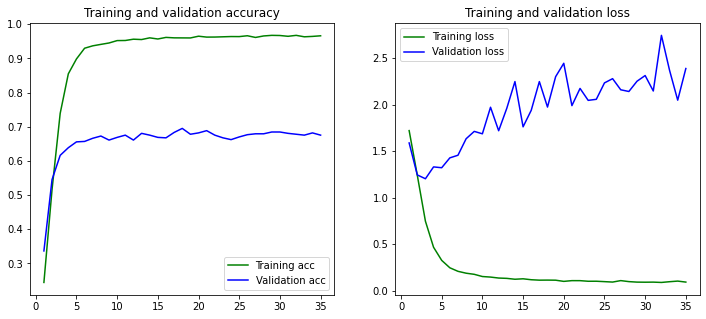

In [21]:
PlotGraph(history)

In [22]:
print(f"Best Accuracy Achieved by Model: {max(history.history['val_accuracy'])}")

Best Accuracy Achieved by Model: 0.6951379776000977


In [23]:
#model.load_weights(checkpoint_filepath)

In [24]:
predict = model.predict(TEST)
predict_class = np.argmax(predict, axis=1)
predict_class = np.array(predict_class)
predict_class

array([4, 4, 5, 1, 2, 0, 0, 2, 5, 2, 3, 3, 4, 1, 2, 2, 0, 4, 3, 5, 4, 2,
       2, 3, 4, 4, 1, 4, 4, 0, 2, 2, 4, 2, 1, 2, 1, 4, 1, 0, 4, 4, 3, 2,
       1, 3, 5, 2, 4, 3, 1, 2, 4, 1, 3, 5, 3, 4, 2, 0, 2, 4, 5, 2, 1, 2,
       5, 0, 0, 2, 0, 5, 5, 2, 1, 4, 3, 5, 5, 0, 0, 0, 3, 2, 4, 4, 0, 2,
       0, 3, 0, 3, 2, 1, 0, 3, 2, 3, 4, 0, 2, 0, 2, 3, 1, 0, 4, 3, 4, 0,
       0, 5, 0, 4, 3, 2, 5, 1, 0, 4, 0, 3, 2, 3, 3, 0, 0, 2, 2, 2, 4, 4,
       3, 2, 2, 4, 4, 2, 2, 4, 3, 2, 1, 5, 0, 4, 2, 2, 2, 1, 3, 4, 5, 0,
       4, 2, 5, 4, 2, 1, 0, 2, 2, 3, 5, 3, 1, 4, 5, 1, 5, 0, 4, 5, 0, 2,
       3, 3, 4, 1, 2, 0, 4, 3, 2, 0, 1, 3, 1, 3, 5, 5, 3, 5, 4, 5, 1, 1,
       0, 5, 0, 1, 2, 1, 0, 4, 2, 2, 1, 1, 4, 1, 0, 2, 4, 0, 4, 1, 4, 5,
       4, 3, 4, 3, 1, 4, 4, 5, 3, 1, 4, 0, 2, 2, 2, 1, 1, 5, 3, 3, 2, 4,
       2, 0, 3, 0, 4, 4, 4, 0, 4, 5, 4, 0, 0, 1, 0, 1, 2, 2, 2, 2, 4, 4,
       3, 2, 3, 3, 3, 4, 5, 2, 5, 4, 2, 4, 4, 1, 3, 1, 1, 5, 0, 3, 2, 2,
       1, 1, 1, 0, 0, 0, 5, 5, 4, 1, 5, 0, 3, 3, 3,

In [25]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_df["label"], predict_class)
cm

array([[90, 10, 11,  7,  5,  5],
       [11, 63, 22,  5, 20,  6],
       [ 2, 11, 91,  6,  7,  3],
       [ 8,  8, 13, 89, 12,  6],
       [ 5,  8, 12,  9, 90,  6],
       [ 3,  7, 10,  5,  4, 91]])

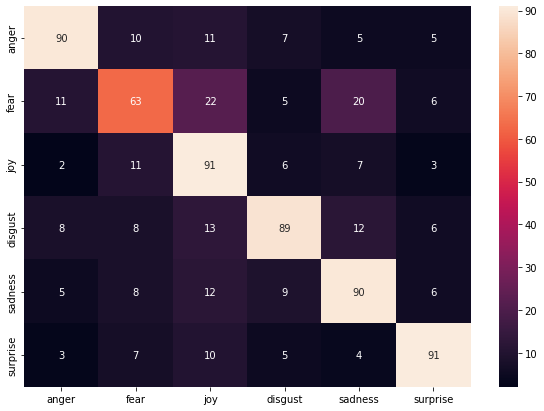

In [26]:
df_cm = pd.DataFrame(cm, index=["anger", "fear", "joy", "disgust", "sadness", "surprise"], columns=["anger", "fear", "joy", "disgust", "sadness", "surprise"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm,annot=True, fmt ="d")

In [27]:
from sklearn.metrics import classification_report

print(classification_report(test_df["label"], predict_class, target_names =["anger", "fear", "joy", "disgust", "sadness", "surprise"]))

              precision    recall  f1-score   support

       anger       0.76      0.70      0.73       128
        fear       0.59      0.50      0.54       127
         joy       0.57      0.76      0.65       120
     disgust       0.74      0.65      0.69       136
     sadness       0.65      0.69      0.67       130
    surprise       0.78      0.76      0.77       120

    accuracy                           0.68       761
   macro avg       0.68      0.68      0.68       761
weighted avg       0.68      0.68      0.67       761

